# Method: LSTM 
# Dataset: KS Equation, L = 60
# Purpose: Prediction

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from functools import partial

import jax
import jax.numpy as jnp
from jax.nn.initializers import glorot_normal, normal
from jax.example_libraries import optimizers

In [3]:
SEED = 42

In [4]:
train, test = load_data("KS, L = 60", "../../data/ks60", 0.5)

In [5]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (90000, 240)
Test size: (90000, 240)


**Create test set**

In [6]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [7]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 2000 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [8]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 240)
Test output size: (100, 400, 240)


# 2. LSTM Implementation

In [9]:
def LSTM(h_dim, data_dim, W_init = glorot_normal(), b_init = normal()):
    """
    args:
    ====
     h_dim: dimension of the internal state
     data_dim: dimensionity of the time series

    outputs:
    ======
     init_fun: function to initialize the parameters
     process: function to process a time-series and compute the final prediction and final internal state
     forecast: function that, given a pair (internal-state, input), computes the next T predictions
    """
    
    def init_fun(rng):
        """
        This function initialize the weights of the RNN
        
        args:
        ====
         rng: jax RNG
         
        outputs:
        ======
         params: a tuple of parameters
        """
        
        # Forget Layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        fU = W_init(k1, (h_dim, data_dim))
        fW = W_init(k2, (h_dim, h_dim)) 
        fb = b_init(k3, (h_dim,))
        
        # Input Layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        iU = W_init(k1, (h_dim, data_dim))
        iW = W_init(k2, (h_dim, h_dim))
        ib = b_init(k3, (h_dim,))
        
        # Candidate layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        gU = W_init(k1, (h_dim, data_dim))
        gW = W_init(k2, (h_dim, h_dim))
        gb = b_init(k3, (h_dim,))
        
        # Output layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        oU = W_init(k1, (h_dim, data_dim))
        oW = W_init(k2, (h_dim, h_dim))
        ob = b_init(k3, (h_dim,))
        
        # Dense layer (hidden -> y)
        k1, k2 = jax.random.split(rng, num = 2)
        dO = W_init(k1, (data_dim, h_dim))
        db = b_init(k2, (data_dim,))
                
        params = fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db
        return params
    
    def process(params, time_series):
        """
        This function takes a time-series in input, pass it through the RNN, 
        and finally outputs the last prediction and internal state
        
        args:
        ====
         params: tuple of parameters
         time_series: data of dimension (T, dim_data)
         
        outputs:
        =======
         c_final: jax vector of dimension nn_size
         h_final: jax vector of dimension nn_size
         pred_traj[-1]: last prediction
        """
        
        fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db = params 
        
        c_zero = np.zeros((h_dim, ))
        h_zero = np.zeros((h_dim, ))
        
        # forward pass
        def process_internal(start, x):
            c, h = start
            
            forget_gate = sigmoid(jnp.dot(fU, x) + jnp.dot(fW, h) + fb)
            input_gate = sigmoid(jnp.dot(iU, x) + jnp.dot(iW, h) + ib)
            cand_gate = jnp.tanh(jnp.dot(gU, x) + jnp.dot(gW, h) + gb)
            c_new = forget_gate * c + input_gate * cand_gate
            output_gate = sigmoid(jnp.dot(oU, x) + jnp.dot(oW, h) + ob)
            h_new = jnp.tanh(c_new) * output_gate
            y = x + dO @ h_new + db
            
            return (c_new, h_new), y
        (c_final, h_final), pred_traj = jax.lax.scan(process_internal, (c_zero, h_zero), time_series)
        return (c_final, h_final), pred_traj[-1]
    
    
    def forecast(params, internal_states, x_input, horizon):
        """
        This function takes in an internal state and a first input and produces 
        prediction over a finite horizon.
        
        args:
        ====
         params: tuple of parameters
         internal_states = (c_internal, h_internal): internal state values of c and h
         x_input: jax vector of dimension dim_data
         horizon: horizon of the prediction
         
        outputs:
        =======
         preds: a trajectory of prediction of dimension (horison, dim_data) 
        """
        c_internal, h_internal = internal_states
        # extract parameters
        fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db = params 
        
        # forward pass
        def forecast_internal(triple_c_h_x, _ ):
            cell, hidden, x = triple_c_h_x
            
            forget_gate = sigmoid(jnp.dot(fU, x) + jnp.dot(fW, hidden) + fb)
            input_gate = sigmoid(jnp.dot(iU, x) + jnp.dot(iW, hidden) + ib)
            cand_gate = jnp.tanh(jnp.dot(gU, x) + jnp.dot(gW, hidden) + gb)
            c_new = forget_gate * cell + input_gate * cand_gate
            output_gate = sigmoid(jnp.dot(oU, x) + jnp.dot(oW, hidden) + ob)
            h_new = jnp.tanh(c_new) * output_gate
            y = x + dO @ h_new + db
            
            return (c_new, h_new, y), y
        
        _, pred_traj = jax.lax.scan(forecast_internal, (c_internal, h_internal, x_input), None, length=horizon)
        
        # return the trajectory of predictions
        return pred_traj
    
    return init_fun, process, forecast

In [17]:
def get_parameters(nn_size, seed, batch_size, L_past, L_forecast_train, 
                   num_epoch, lr_schedule, early_stopping = EARLY_STOPPING, 
                  early_stopping_baseline = 2.):
    assert len(num_epoch) == len(lr_schedule)
    def training(x, y, init_params):
        @jax.jit
        def step(i, opt_state, x_batch, y_batch):
            params = get_params(opt_state)
            value, g = jax.value_and_grad(mse)(params, x_batch, y_batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        @partial(jax.jit, static_argnums=2)
        def make_forecast(params, x_batch, horizon):
            # pass the data through the RNN. 
            # note that "preds" is the first forecasts
            hs, preds = process_batch(params, x_batch)
            # compute the (L_forecast-1) next forecasts
            y_pred = forecast_batch(params, hs, preds, horizon-1)
            #stick all the forecasts together
            y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

            return y_pred

        @jax.jit
        def mse(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the MSE.

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             MSE: MSE between forecasts and targets
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred = make_forecast(params, x_batch, L_forecast)

            #compute MSE
            error = y_pred - y_truth
            mu_loss = jnp.mean(error**2)
            return mu_loss 
        
        start = time()
                
        loss_train_traj = []
        loss_train_all_traj = []
        
        best_params = init_params
        overall_best_mse = 999999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test + L_past))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(L_past)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(L_past,L_past+L_forecast_test)[None,:]).astype(int) 
        x_val = x[t_past_batch_val]
        y_val = y[t_pred_batch_val]
        
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the training data
                T_indices = np.arange(t_size - (L_forecast_train + L_past))
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch
                    # create 2d array of dimension (batch_size, L_past) containing all the time indices
                    t_past_batch = (t_start[:,None] + np.arange(L_past)[None,:]).astype(int) # transposes data
                    t_pred_batch = (t_start[:,None] + np.arange(L_past,L_past+L_forecast_train)[None,:]).astype(int) 

                    #create batch of dimension (batch_size, L_past, data_dim)
                    x_batch = x[t_past_batch]  
                    y_batch = y[t_pred_batch]

                    params, opt_state, loss_current = step(k, opt_state, x_batch, y_batch) # update
                    loss_epoch_train.append(loss_current)
                
                mse_train = np.mean(loss_epoch_train)
                
                # validation             
                mse_val = mse(params, x_val, y_val)
                
                if  best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch >= 100):
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                
                if (best_mse < early_stopping_baseline or mse_val > 1000) and counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            print(f"Best Validation MSE: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return overall_best_params

    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    # Initialize LSTM
    init_fun, process, forecast = LSTM(nn_size, data_dim)       # LSTM Network
    process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
    forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)
    init_params = init_fun(key)
    
    final_params = training(x, y, init_params)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return final_params, (process_batch, forecast_batch)

In [18]:
def get_test_pred(data_test, params, lstm_fx):  
    @partial(jax.jit, static_argnums=2)
    def make_forecast(params, x_batch, horizon):
        pbatch, fbatch = lstm_fx
        # pass the data through the RNN. 
        # note that "preds" is the first forecasts
        hs, preds = pbatch(params, x_batch)
        # compute the (L_forecast-1) next forecasts
        y_pred = fbatch(params, hs, preds, horizon-1)
        #stick all the forecasts together
        y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

        return y_pred

    @jax.jit
    def loss(params, x_batch, y_truth):
        """
        For each time-series in a batch, forecasts over a finite horizon 
        and compute the MSE.

        args:
        ====
         params: neural parameters
         x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
         y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

        outputs:
        =======
         MSE: MSE between forecasts and targets

        """

        # horizon of the forecast
        L_forecast = y_truth.shape[1]    
        y_pred = make_forecast(params, x_batch, L_forecast)

        #compute MSE
        error = y_pred - y_truth
        return jnp.mean(error**2)
    
    start = time()
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data
    mu_pred = make_forecast(params, data_test, L_forecast_test)
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mu_pred)

# 3. Parameter tuning

There are 3 parameters to tune
- nn_size [100, 500, 1000, 1500] - size of the hidden layer
- L_forecast_train [4, 8, 16] - steps forward considered when calculating loss during training
- L_past [1, 8, 16] - length of time series used as input during training 

As a full grid search will be computationally expensive, nn_size is first tuned using a fixed L_forecast_train and L_past, then a grid search is performed on the optimal nn_size

## 3.1 nn_size

**Parameters**
- nn_size = [100, 500, 1000, 1500]
- L_forecast_train = 8
- L_past = 4

In [19]:
L_forecast_train = 8
L_past = 4
b_size = 128 # Batch size
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

### 3.1.1 nn_size = 100

In [20]:
nn_size = 100

In [21]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,)

Backpropogation start

Epoch 10: Time taken = 3.21 | Train loss = 0.0028602 | Val loss =  37.4090729
Epoch 20: Time taken = 2.90 | Train loss = 0.0014637 | Val loss =  19.5982647
Epoch 30: Time taken = 2.99 | Train loss = 0.0010610 | Val loss =  71.4267883
Epoch 40: Time taken = 2.89 | Train loss = 0.0008331 | Val loss =  12.0050716
Epoch 50: Time taken = 3.32 | Train loss = 0.0007270 | Val loss =  9.0114202
Epoch 60: Time taken = 3.08 | Train loss = 0.0006374 | Val loss =  10.9739361
Epoch 70: Time taken = 3.01 | Train loss = 0.0005812 | Val loss =  5.1837978
Epoch 80: Time taken = 3.02 | Train loss = 0.0005223 | Val loss =  3.3080621
Epoch 90: Time taken = 2.96 | Train loss = 0.0004819 | Val loss =  3.5982380
Epoch 100: Time taken = 3.03 | Train loss = 0.0004604 | Val loss =  7.3089375
Epoch 110: Time taken = 2.98 | Train loss = 0.0004439 | Val loss =  11.3973675
Epoch 120: Time taken = 3.02 | Train loss = 0.0004224 | Val loss =  3.2376394
Epoch 128: Time taken = 2.99 | Train loss = 

In [22]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_1_1_mu_preds.pkl")

Testing complete. Time taken: 0.77


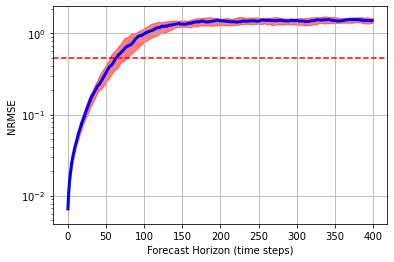

It takes around t = 16.00 for mean error to exceed 0.5


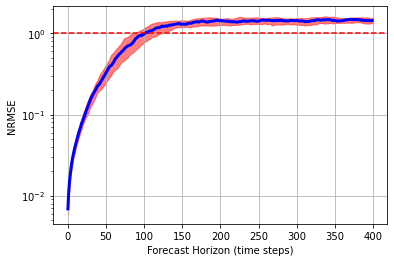

It takes around t = 25.50 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.087
Median NRMSE at t = 0.5: 0.330
Median NRMSE at t = 1: 0.987
Median NRMSE at t = 2: 1.429
Median NRMSE at t = 3: 1.443


In [23]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = 0.25)
res_single.plot_rmse(error_thresh = 1., dt = 0.25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.2 nn_size = 500

In [24]:
nn_size = 500
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

In [25]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 4.33 | Train loss = 0.0011850 | Val loss =  472.8016663
Epoch 20: Time taken = 4.35 | Train loss = 0.0005153 | Val loss =  49.8036346
Epoch 30: Time taken = 4.36 | Train loss = 0.0003680 | Val loss =  3.1901441
Epoch 40: Time taken = 4.34 | Train loss = 0.0002525 | Val loss =  1.7219779
Epoch 50: Time taken = 4.35 | Train loss = 0.0002078 | Val loss =  1.5402451
Epoch 60: Time taken = 4.34 | Train loss = 0.0001755 | Val loss =  1.4826488
Epoch 70: Time taken = 4.37 | Train loss = 0.0001723 | Val loss =  1.5319203
Epoch 80: Time taken = 4.36 | Train loss = 0.0001439 | Val loss =  1.4799887
Epoch 90: Time taken = 4.36 | Train loss = 0.0001411 | Val loss =  1.4473761
Epoch 100: Time taken = 4.36 | Train loss = 0.0001442 | Val loss =  1.3994459
Epoch 110: Time taken = 4.36 | Train loss = 0.0001133 | Val loss =  1.5448298
EARLY STOPPING. Epoch 118: Train loss = 0.0001062 | Val loss =  1.4004068
Best Validation MSE: 1.3782833
IMPROVED VALIDATION 

In [26]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_1_2_mu_preds.pkl")

Testing complete. Time taken: 0.99


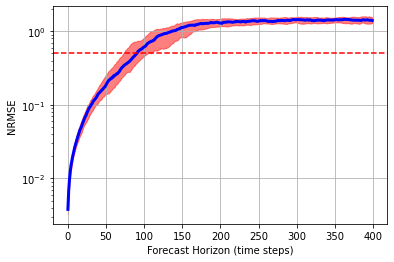

It takes around t = 22.75 for mean error to exceed 0.5


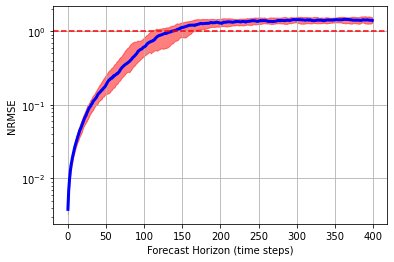

It takes around t = 34.00 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.059
Median NRMSE at t = 0.5: 0.188
Median NRMSE at t = 1: 0.613
Median NRMSE at t = 2: 1.294
Median NRMSE at t = 3: 1.439


In [27]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = 0.25)
res_single.plot_rmse(error_thresh = 1., dt = 0.25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.3 nn_size = 1000

In [28]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate
nn_size = 1000

In [29]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 9.90 | Train loss = 0.0009377 | Val loss =  142.0169373
Epoch 20: Time taken = 9.94 | Train loss = 0.0003928 | Val loss =  1.9742799
Epoch 30: Time taken = 9.90 | Train loss = 0.0002649 | Val loss =  1.6390558
Epoch 40: Time taken = 9.91 | Train loss = 0.0002201 | Val loss =  1.5495636
Epoch 50: Time taken = 9.91 | Train loss = 0.0001509 | Val loss =  1.4734031
Epoch 60: Time taken = 9.91 | Train loss = 0.0001619 | Val loss =  1.4273798
Epoch 70: Time taken = 9.91 | Train loss = 0.0001282 | Val loss =  1.4624228
Epoch 80: Time taken = 9.90 | Train loss = 0.0001343 | Val loss =  1.4438950
Epoch 90: Time taken = 9.90 | Train loss = 0.0001325 | Val loss =  1.4918133
Epoch 100: Time taken = 9.91 | Train loss = 0.0001368 | Val loss =  1.4798620
EARLY STOPPING. Epoch 107: Train loss = 0.0000884 | Val loss =  1.4328744
Best Validation MSE: 1.3922896
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 9.90 | Train loss = 0.0001420 | Val loss =  1.40283

In [30]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_1_3_mu_preds.pkl")

Testing complete. Time taken: 1.51


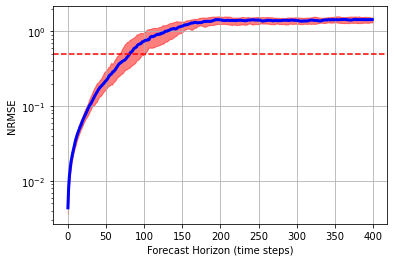

It takes around t = 20.25 for mean error to exceed 0.5


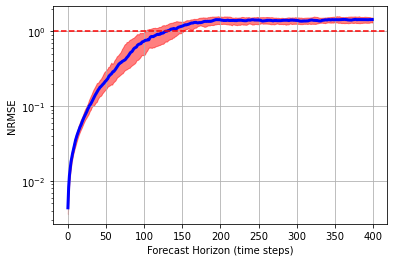

It takes around t = 32.00 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.067
Median NRMSE at t = 0.5: 0.219
Median NRMSE at t = 1: 0.741
Median NRMSE at t = 2: 1.428
Median NRMSE at t = 3: 1.403


In [31]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 nn_size = 1500

In [32]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [200, 200, 200]  # Number of epochs for each learning rate
nn_size = 1500

In [33]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 18.03 | Train loss = 0.0009289 | Val loss =  16.8504238
Epoch 20: Time taken = 18.00 | Train loss = 0.0003782 | Val loss =  1.5989983
Epoch 30: Time taken = 18.10 | Train loss = 0.0003204 | Val loss =  1.5206069
Epoch 40: Time taken = 18.00 | Train loss = 0.0002043 | Val loss =  1.5159941
Epoch 50: Time taken = 18.03 | Train loss = 0.0001686 | Val loss =  1.4620290
Epoch 60: Time taken = 18.08 | Train loss = 0.0001793 | Val loss =  1.4470451
Epoch 70: Time taken = 18.06 | Train loss = 0.0001622 | Val loss =  1.4909425
Epoch 80: Time taken = 18.14 | Train loss = 0.0001081 | Val loss =  1.4219147
Epoch 90: Time taken = 18.11 | Train loss = 0.0001439 | Val loss =  1.5109055
Epoch 100: Time taken = 18.05 | Train loss = 0.0001242 | Val loss =  1.4464712
EARLY STOPPING. Epoch 106: Train loss = 0.0001078 | Val loss =  1.4624677
Best Validation MSE: 1.3928012
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 18.08 | Train loss = 0.0000986 | Val loss 

In [34]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_1_4_mu_preds.pkl")

Testing complete. Time taken: 2.36


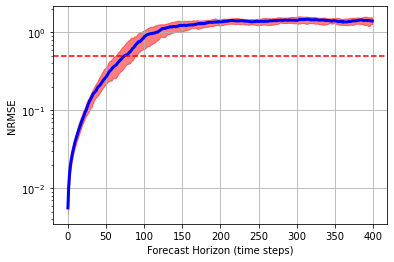

It takes around t = 18.75 for mean error to exceed 0.5


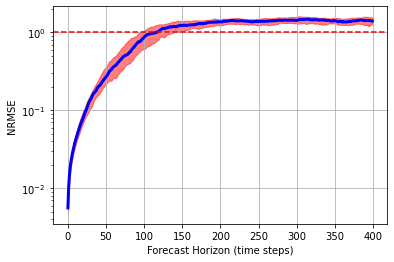

It takes around t = 29.00 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.081
Median NRMSE at t = 0.5: 0.268
Median NRMSE at t = 1: 0.876
Median NRMSE at t = 2: 1.363
Median NRMSE at t = 3: 1.425


In [35]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 L_forecast_train + L_past

**Parameters**
- nn_size = 1000
- L_forecast_train = [1, 8, 16]
- L_past = [4, 8, 16]

In [36]:
nn_size = 500
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

### 3.2.1 L_forecast_train = 4, L_past = 1

In [37]:
L_forecast_train = 4; L_past = 1

In [38]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.91 | Train loss = 0.0002966 | Val loss =  707.3223877
Epoch 20: Time taken = 1.88 | Train loss = 0.0001555 | Val loss =  35.9282722
Epoch 30: Time taken = 2.14 | Train loss = 0.0001281 | Val loss =  4.1921058
Epoch 40: Time taken = 1.97 | Train loss = 0.0001117 | Val loss =  1.8075829
Epoch 50: Time taken = 1.98 | Train loss = 0.0000909 | Val loss =  1.8328607
Epoch 60: Time taken = 1.93 | Train loss = 0.0000826 | Val loss =  2.1453283
Epoch 70: Time taken = 2.40 | Train loss = 0.0000849 | Val loss =  2.2390773
Epoch 80: Time taken = 2.29 | Train loss = 0.0000737 | Val loss =  2.0020740
Epoch 90: Time taken = 2.06 | Train loss = 0.0000692 | Val loss =  2.0110116
Epoch 100: Time taken = 1.99 | Train loss = 0.0000711 | Val loss =  1.7104129
Epoch 110: Time taken = 2.04 | Train loss = 0.0000650 | Val loss =  1.7345939
EARLY STOPPING. Epoch 116: Train loss = 0.0000605 | Val loss =  1.8145299
Best Validation MSE: 1.6660374
IMPROVED VALIDATION 

In [39]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_2_1_mu_preds.pkl")

Testing complete. Time taken: 0.91


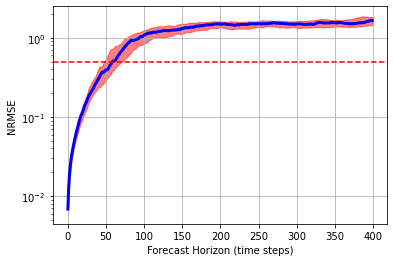

It takes around t = 14.75 for mean error to exceed 0.5


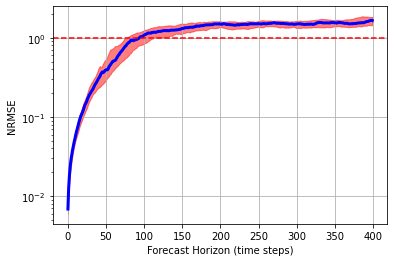

It takes around t = 23.50 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.121
Median NRMSE at t = 0.5: 0.393
Median NRMSE at t = 1: 1.080
Median NRMSE at t = 2: 1.486
Median NRMSE at t = 3: 1.498


In [40]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 L_forecast_train = 4, L_past = 4

In [41]:
L_forecast_train = 4; L_past = 4

In [42]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 3.02 | Train loss = 0.0003485 | Val loss =  2671.5957031
Epoch 20: Time taken = 2.98 | Train loss = 0.0001890 | Val loss =  591.0819702
Epoch 30: Time taken = 2.99 | Train loss = 0.0001143 | Val loss =  281.0816345
Epoch 40: Time taken = 2.96 | Train loss = 0.0000960 | Val loss =  11.1260843
Epoch 50: Time taken = 2.98 | Train loss = 0.0000879 | Val loss =  2.7926188
Epoch 60: Time taken = 2.99 | Train loss = 0.0000685 | Val loss =  1.8387871
Epoch 70: Time taken = 2.97 | Train loss = 0.0000654 | Val loss =  1.5450085
Epoch 80: Time taken = 2.97 | Train loss = 0.0000579 | Val loss =  1.5946853
Epoch 90: Time taken = 2.97 | Train loss = 0.0000578 | Val loss =  1.5909908
Epoch 100: Time taken = 2.96 | Train loss = 0.0000460 | Val loss =  1.6869880
Epoch 110: Time taken = 2.97 | Train loss = 0.0000476 | Val loss =  1.5077705
Epoch 120: Time taken = 2.97 | Train loss = 0.0000419 | Val loss =  1.5551026
EARLY STOPPING. Epoch 126: Train loss = 0.

In [43]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 0.98


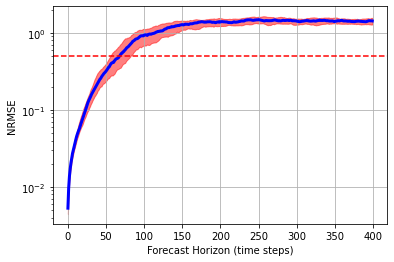

It takes around t = 17.00 for mean error to exceed 0.5


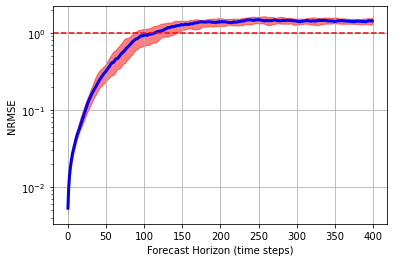

It takes around t = 28.75 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.081
Median NRMSE at t = 0.5: 0.319
Median NRMSE at t = 1: 0.936
Median NRMSE at t = 2: 1.388
Median NRMSE at t = 3: 1.418


In [44]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.3 L_forecast_train = 4, L_past = 8

In [45]:
L_forecast_train = 4; L_past = 8

In [46]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 4.30 | Train loss = 0.0004424 | Val loss =  3285.0622559
Epoch 20: Time taken = 4.22 | Train loss = 0.0001653 | Val loss =  1237.2440186
Epoch 30: Time taken = 4.21 | Train loss = 0.0001244 | Val loss =  319.8836060
Epoch 40: Time taken = 4.22 | Train loss = 0.0000931 | Val loss =  9.8850222
Epoch 50: Time taken = 4.21 | Train loss = 0.0000881 | Val loss =  3.0274951
Epoch 60: Time taken = 4.22 | Train loss = 0.0000708 | Val loss =  1.5999241
Epoch 70: Time taken = 4.21 | Train loss = 0.0000615 | Val loss =  1.6861721
Epoch 80: Time taken = 4.21 | Train loss = 0.0000427 | Val loss =  1.4978104
Epoch 90: Time taken = 4.46 | Train loss = 0.0000523 | Val loss =  1.6114043
Epoch 100: Time taken = 4.17 | Train loss = 0.0000537 | Val loss =  1.5728247
EARLY STOPPING. Epoch 109: Train loss = 0.0000405 | Val loss =  1.5548077
Best Validation MSE: 1.4911768
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 4.16 | Train loss = 0.0000575 | Val loss =  1

In [47]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 0.88


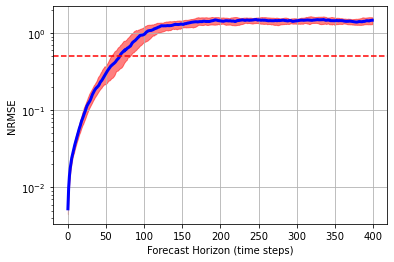

It takes around t = 17.00 for mean error to exceed 0.5


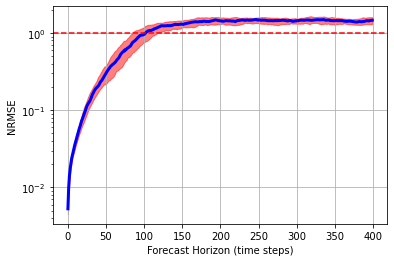

It takes around t = 25.50 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.083
Median NRMSE at t = 0.5: 0.302
Median NRMSE at t = 1: 0.960
Median NRMSE at t = 2: 1.437
Median NRMSE at t = 3: 1.436


In [48]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.4 L_forecast_train = 8, L_past = 1

In [49]:
L_forecast_train = 8; L_past = 1

In [50]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 3.45 | Train loss = 0.0010434 | Val loss =  140.1412201
Epoch 20: Time taken = 3.47 | Train loss = 0.0004317 | Val loss =  2.7390761
Epoch 30: Time taken = 3.47 | Train loss = 0.0003497 | Val loss =  1.5583115
Epoch 40: Time taken = 3.46 | Train loss = 0.0002896 | Val loss =  1.4894894
Epoch 50: Time taken = 3.48 | Train loss = 0.0002604 | Val loss =  1.4489073
Epoch 60: Time taken = 3.48 | Train loss = 0.0002205 | Val loss =  1.4746815
Epoch 70: Time taken = 3.62 | Train loss = 0.0001753 | Val loss =  1.4689987
Epoch 80: Time taken = 3.56 | Train loss = 0.0001826 | Val loss =  1.4273980
Epoch 90: Time taken = 3.63 | Train loss = 0.0001674 | Val loss =  1.4171221
Epoch 100: Time taken = 3.71 | Train loss = 0.0001617 | Val loss =  1.4264256
Epoch 105: Time taken = 3.61 | Train loss = 0.0001526 | Val loss =  1.3898510
Epoch 106: Time taken = 3.59 | Train loss = 0.0001503 | Val loss =  1.3842832
Epoch 110: Time taken = 3.60 | Train loss = 0.00

In [51]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 0.87


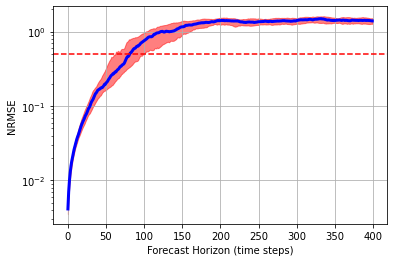

It takes around t = 20.25 for mean error to exceed 0.5


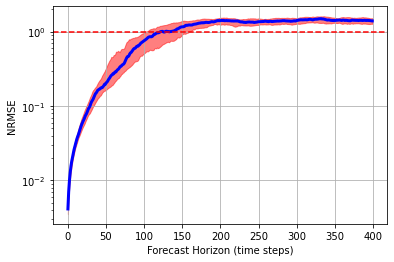

It takes around t = 30.50 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.063
Median NRMSE at t = 0.5: 0.204
Median NRMSE at t = 1: 0.756
Median NRMSE at t = 2: 1.410
Median NRMSE at t = 3: 1.417


In [52]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.5 L_forecast_train = 8, L_past = 4

In [53]:
L_forecast_train = 8; L_past = 4

In [54]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 4.40 | Train loss = 0.0011850 | Val loss =  472.8016663
Epoch 20: Time taken = 4.38 | Train loss = 0.0005153 | Val loss =  49.8036346
Epoch 30: Time taken = 4.40 | Train loss = 0.0003680 | Val loss =  3.1901441
Epoch 40: Time taken = 4.40 | Train loss = 0.0002525 | Val loss =  1.7219779
Epoch 50: Time taken = 4.38 | Train loss = 0.0002078 | Val loss =  1.5402451
Epoch 60: Time taken = 4.39 | Train loss = 0.0001755 | Val loss =  1.4826488
Epoch 70: Time taken = 4.84 | Train loss = 0.0001723 | Val loss =  1.5319203
Epoch 80: Time taken = 4.46 | Train loss = 0.0001439 | Val loss =  1.4799887
Epoch 90: Time taken = 4.47 | Train loss = 0.0001411 | Val loss =  1.4473761
Epoch 100: Time taken = 4.45 | Train loss = 0.0001442 | Val loss =  1.3994459
Epoch 110: Time taken = 4.45 | Train loss = 0.0001133 | Val loss =  1.5448298
EARLY STOPPING. Epoch 118: Train loss = 0.0001062 | Val loss =  1.4004068
Best Validation MSE: 1.3782833
IMPROVED VALIDATION 

In [55]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 0.90


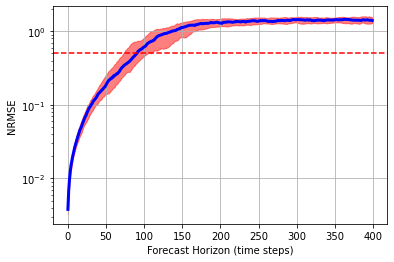

It takes around t = 22.75 for mean error to exceed 0.5


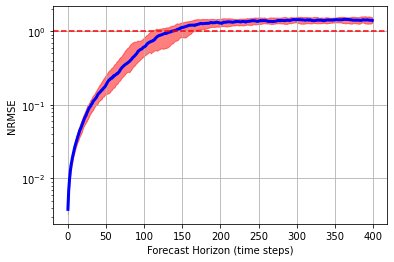

It takes around t = 34.00 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.059
Median NRMSE at t = 0.5: 0.188
Median NRMSE at t = 1: 0.613
Median NRMSE at t = 2: 1.294
Median NRMSE at t = 3: 1.439


In [56]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.6 L_forecast_train = 8, L_past = 8

In [57]:
L_forecast_train = 8; L_past = 8

In [58]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 5.70 | Train loss = 0.0013482 | Val loss =  617.5595703
Epoch 20: Time taken = 5.67 | Train loss = 0.0005106 | Val loss =  44.9785156
Epoch 30: Time taken = 5.70 | Train loss = 0.0003731 | Val loss =  1.8993311
Epoch 40: Time taken = 5.70 | Train loss = 0.0008256 | Val loss =  1.6215158
Epoch 50: Time taken = 5.69 | Train loss = 0.0002581 | Val loss =  1.6493776
Epoch 60: Time taken = 5.68 | Train loss = 0.0002134 | Val loss =  1.6048942
Epoch 70: Time taken = 5.70 | Train loss = 0.0001692 | Val loss =  1.4962069
Epoch 80: Time taken = 5.71 | Train loss = 0.0001406 | Val loss =  1.4903497
Epoch 90: Time taken = 5.72 | Train loss = 0.0001484 | Val loss =  1.3968768
Epoch 100: Time taken = 5.75 | Train loss = 0.0001501 | Val loss =  1.4442025
Epoch 110: Time taken = 5.67 | Train loss = 0.0001359 | Val loss =  1.4591247
Epoch 112: Time taken = 5.62 | Train loss = 0.0001127 | Val loss =  1.3588800
Epoch 120: Time taken = 5.68 | Train loss = 0.0

In [59]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 0.89


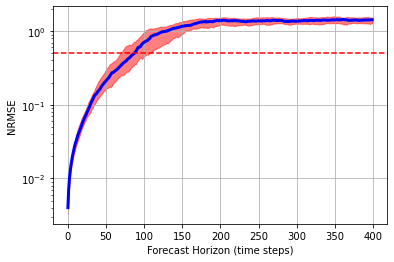

It takes around t = 22.00 for mean error to exceed 0.5


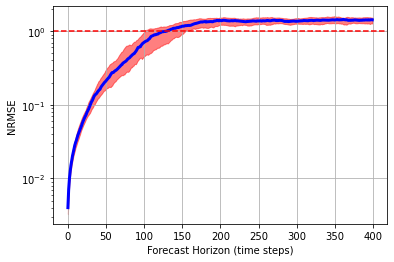

It takes around t = 32.25 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.060
Median NRMSE at t = 0.5: 0.212
Median NRMSE at t = 1: 0.706
Median NRMSE at t = 2: 1.396
Median NRMSE at t = 3: 1.365


In [60]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.7 L_forecast_train = 16, L_past = 1

In [61]:
L_forecast_train = 16; L_past = 1

In [62]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 6.30 | Train loss = 0.0047119 | Val loss =  2.7513447
Epoch 20: Time taken = 6.28 | Train loss = 0.0018297 | Val loss =  1.4769106
Epoch 30: Time taken = 6.30 | Train loss = 0.0013043 | Val loss =  1.4854364
Epoch 40: Time taken = 6.29 | Train loss = 0.0010047 | Val loss =  1.3836492
Epoch 50: Time taken = 6.29 | Train loss = 0.0009339 | Val loss =  1.4317528
Epoch 60: Time taken = 6.30 | Train loss = 0.0007720 | Val loss =  1.4098651
Epoch 70: Time taken = 6.29 | Train loss = 0.0006917 | Val loss =  1.4056576
Epoch 80: Time taken = 6.64 | Train loss = 0.0005636 | Val loss =  1.4235721
Epoch 90: Time taken = 6.42 | Train loss = 0.0006001 | Val loss =  1.4204040
Epoch 100: Time taken = 6.31 | Train loss = 0.0005961 | Val loss =  1.3824530
EARLY STOPPING. Epoch 105: Train loss = 0.0004854 | Val loss =  1.3665974
Best Validation MSE: 1.3548453
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 6.18 | Train loss = 0.0006109 | Val loss =  1.4066944

In [63]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 1.06


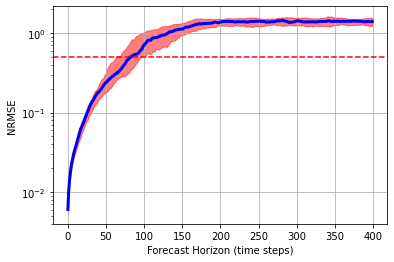

It takes around t = 20.75 for mean error to exceed 0.5


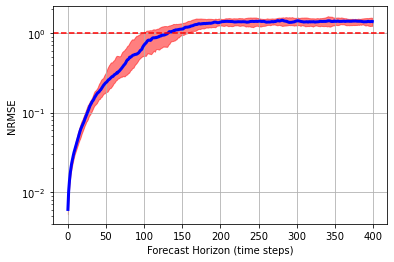

It takes around t = 33.00 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.073
Median NRMSE at t = 0.5: 0.238
Median NRMSE at t = 1: 0.708
Median NRMSE at t = 2: 1.369
Median NRMSE at t = 3: 1.416


In [64]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.8 L_forecast_train = 16, L_past = 4

In [65]:
L_forecast_train = 16; L_past = 4

In [66]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 7.47 | Train loss = 0.0049926 | Val loss =  2.4817970
Epoch 20: Time taken = 7.61 | Train loss = 0.0021375 | Val loss =  1.5588816
Epoch 30: Time taken = 7.13 | Train loss = 0.0014711 | Val loss =  1.5117530
Epoch 40: Time taken = 7.15 | Train loss = 0.0009563 | Val loss =  1.4149863
Epoch 50: Time taken = 7.13 | Train loss = 0.0007302 | Val loss =  1.4969742
Epoch 60: Time taken = 7.12 | Train loss = 0.0006402 | Val loss =  1.4119174
Epoch 70: Time taken = 7.14 | Train loss = 0.0007052 | Val loss =  1.4316078
Epoch 80: Time taken = 7.13 | Train loss = 0.0005875 | Val loss =  1.4991316
Epoch 90: Time taken = 7.13 | Train loss = 0.0004649 | Val loss =  1.4873167
Epoch 100: Time taken = 7.11 | Train loss = 0.0005315 | Val loss =  1.4412169
Epoch 110: Time taken = 7.11 | Train loss = 0.0005035 | Val loss =  1.4422389
Epoch 120: Time taken = 7.11 | Train loss = 0.0004824 | Val loss =  1.3666781
Epoch 121: Time taken = 7.13 | Train loss = 0.0004

In [67]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 0.82


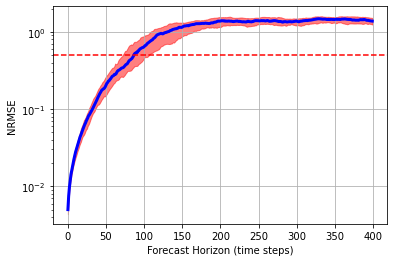

It takes around t = 21.75 for mean error to exceed 0.5


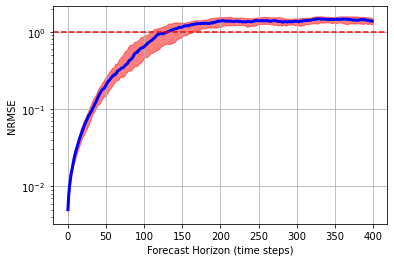

It takes around t = 32.75 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.056
Median NRMSE at t = 0.5: 0.204
Median NRMSE at t = 1: 0.644
Median NRMSE at t = 2: 1.376
Median NRMSE at t = 3: 1.371


In [68]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.9 L_forecast_train = 16, L_past = 8

In [69]:
L_forecast_train = 16; L_past = 8

In [70]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 8.43 | Train loss = 0.0053246 | Val loss =  3.7400715
Epoch 20: Time taken = 8.42 | Train loss = 0.0021974 | Val loss =  1.5661337
Epoch 30: Time taken = 8.44 | Train loss = 0.0013451 | Val loss =  1.5427887
Epoch 40: Time taken = 8.44 | Train loss = 0.0012019 | Val loss =  1.4772508
Epoch 50: Time taken = 8.44 | Train loss = 0.0008335 | Val loss =  1.4881750
Epoch 60: Time taken = 8.41 | Train loss = 0.0006458 | Val loss =  1.4568063
Epoch 70: Time taken = 8.43 | Train loss = 0.0006425 | Val loss =  1.4501221
Epoch 80: Time taken = 8.43 | Train loss = 0.0225065 | Val loss =  1.8780005
Epoch 90: Time taken = 8.42 | Train loss = 0.0007146 | Val loss =  1.3700551
Epoch 100: Time taken = 8.42 | Train loss = 0.0005359 | Val loss =  1.4596639
Epoch 110: Time taken = 8.44 | Train loss = 0.0005624 | Val loss =  1.4280555
Epoch 120: Time taken = 8.44 | Train loss = 0.0004496 | Val loss =  1.4605426
EARLY STOPPING. Epoch 120: Train loss = 0.0004496 

In [71]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 0.83


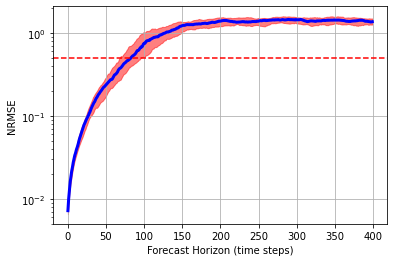

It takes around t = 20.75 for mean error to exceed 0.5


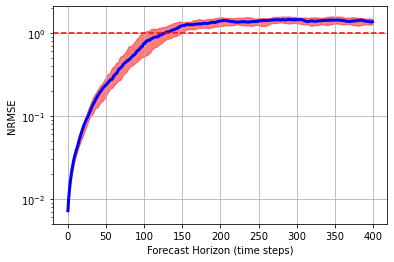

It takes around t = 32.00 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.073
Median NRMSE at t = 0.5: 0.238
Median NRMSE at t = 1: 0.754
Median NRMSE at t = 2: 1.395
Median NRMSE at t = 3: 1.449


In [72]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Best Model

nn_size = 1000  
L_forecast_train = 8  
L_past = 4

In [73]:
nn_size = 500
L_forecast_train = 8
L_past = 4

b_size = 128 # Batch size
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [500, 200, 200]  # Number of epochs for each learning rate

In [74]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,
                                early_stopping = 100)

Backpropogation start

Epoch 10: Time taken = 4.29 | Train loss = 0.0011850 | Val loss =  472.8016663
Epoch 20: Time taken = 4.33 | Train loss = 0.0005153 | Val loss =  49.8036346
Epoch 30: Time taken = 4.33 | Train loss = 0.0003680 | Val loss =  3.1901441
Epoch 40: Time taken = 4.33 | Train loss = 0.0002525 | Val loss =  1.7219779
Epoch 50: Time taken = 4.33 | Train loss = 0.0002078 | Val loss =  1.5402451
Epoch 60: Time taken = 4.34 | Train loss = 0.0001755 | Val loss =  1.4826488
Epoch 70: Time taken = 4.33 | Train loss = 0.0001723 | Val loss =  1.5319203
Epoch 80: Time taken = 4.35 | Train loss = 0.0001439 | Val loss =  1.4799887
Epoch 90: Time taken = 4.34 | Train loss = 0.0001411 | Val loss =  1.4473761
Epoch 100: Time taken = 4.34 | Train loss = 0.0001442 | Val loss =  1.3994459
Epoch 110: Time taken = 4.34 | Train loss = 0.0001133 | Val loss =  1.5448298
Epoch 120: Time taken = 4.34 | Train loss = 0.0001142 | Val loss =  1.4329542
Epoch 130: Time taken = 4.34 | Train loss = 0.0

In [75]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 0.83


In [76]:
save_obj(params, "results/lstm", "best_params.pkl")
save_obj(mean_pred, "results/lstm", "best_mu_preds.pkl")

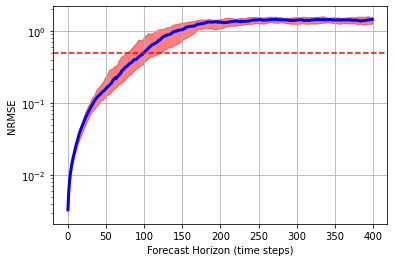

It takes around t = 25.00 for mean error to exceed 0.5


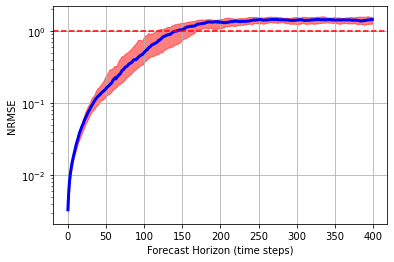

It takes around t = 35.75 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.051
Median NRMSE at t = 0.5: 0.159
Median NRMSE at t = 1: 0.504
Median NRMSE at t = 2: 1.320
Median NRMSE at t = 3: 1.420


In [77]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 5. Plot images based on Lyapunov Time

In [12]:
# nn_size = 500
# _, process, forecast = LSTM(nn_size, data_dim)       # LSTM Network
# process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
# forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)

In [13]:
# params = load_obj("results/lstm/best_params.pkl")

In [78]:
# mean_pred = get_test_pred(X_test, params, (process_batch, forecast_batch))
save_obj(mean_pred, "results", "lstm_pred.pkl")

In [79]:
mean_pred = load_obj("results/lstm_pred.pkl")

In [80]:
total_lyapunov_time_pred = 100 / KS_LT # Amount of Lyapunov Time in Test set

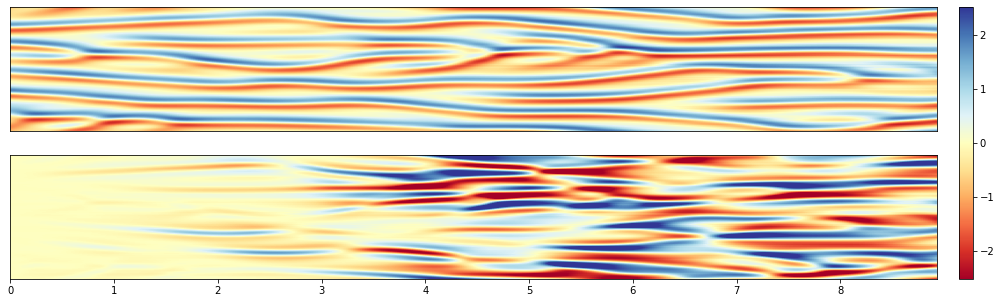

In [81]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "ks_lstm_edited", pred_only=True)

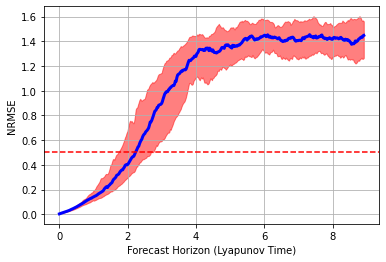

It takes around 2.23 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.059
Median NRMSE at 1.0 Lyapunov Time: 0.138
Median NRMSE at 2.0 Lyapunov Time: 0.400
Median NRMSE at 5.0 Lyapunov Time: 1.353


In [82]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "ks")
res_single.plot_rmse(save_name = "ks_lstm_ph_edited")
print()
res_single.get_loss()